In [66]:
# Loading libraries

In [67]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt; plt.rcdefaults()
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, MinMaxScaler
from keras.layers import Dense, LSTM, Bidirectional, Dropout
from keras.models import Sequential

In [68]:
# Loading dataset from https://www.kaggle.com/hmavrodiev/london-bike-sharing-dataset

In [69]:
df = pd.read_csv('/content/london_merged.csv')
df.head()

,timestamp,cnt,t1,t2,hum,wind_speed,weather_code,is_holiday,is_weekend,season
0,2015-01-04 00:00:00,182,3.0,2.0,93.0,6.0,3.0,0.0,1.0,3.0
1,2015-01-04 01:00:00,138,3.0,2.5,93.0,5.0,1.0,0.0,1.0,3.0
2,2015-01-04 02:00:00,134,2.5,2.5,96.5,0.0,1.0,0.0,1.0,3.0
3,2015-01-04 03:00:00,72,2.0,2.0,100.0,0.0,1.0,0.0,1.0,3.0
4,2015-01-04 04:00:00,47,2.0,0.0,93.0,6.5,1.0,0.0,1.0,3.0


In [79]:
# cnt = count of bike = target column 

In [62]:
# Look at the info

In [70]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17414 entries, 0 to 17413
Data columns (total 10 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   timestamp     17414 non-null  object 
 1   cnt           17414 non-null  int64  
 2   t1            17414 non-null  float64
 3   t2            17414 non-null  float64
 4   hum           17414 non-null  float64
 5   wind_speed    17414 non-null  float64
 6   weather_code  17414 non-null  float64
 7   is_holiday    17414 non-null  float64
 8   is_weekend    17414 non-null  float64
 9   season        17414 non-null  float64
dtypes: float64(8), int64(1), object(1)
memory usage: 1.3+ MB


In [71]:
# Converting and adding columns

In [72]:
df.weather_code = df.weather_code.astype('int32')
df.season = df.season.astype('int32')

In [73]:
df['timestamp'] = pd.to_datetime(df['timestamp'])
df["hour"] = df['timestamp'].dt.hour
df["day_of_month"] = df['timestamp'].dt.day
df["day_of_week"]  = df['timestamp'].dt.dayofweek
df["month"] = df['timestamp'].dt.month

In [74]:
df.head()

,timestamp,cnt,t1,t2,hum,wind_speed,weather_code,is_holiday,is_weekend,season,hour,day_of_month,day_of_week,month
0,2015-01-04 00:00:00,182,3.0,2.0,93.0,6.0,3,0.0,1.0,3,0,4,6,1
1,2015-01-04 01:00:00,138,3.0,2.5,93.0,5.0,1,0.0,1.0,3,1,4,6,1
2,2015-01-04 02:00:00,134,2.5,2.5,96.5,0.0,1,0.0,1.0,3,2,4,6,1
3,2015-01-04 03:00:00,72,2.0,2.0,100.0,0.0,1,0.0,1.0,3,3,4,6,1
4,2015-01-04 04:00:00,47,2.0,0.0,93.0,6.5,1,0.0,1.0,3,4,4,6,1


In [ ]:
# Let's plot graphs

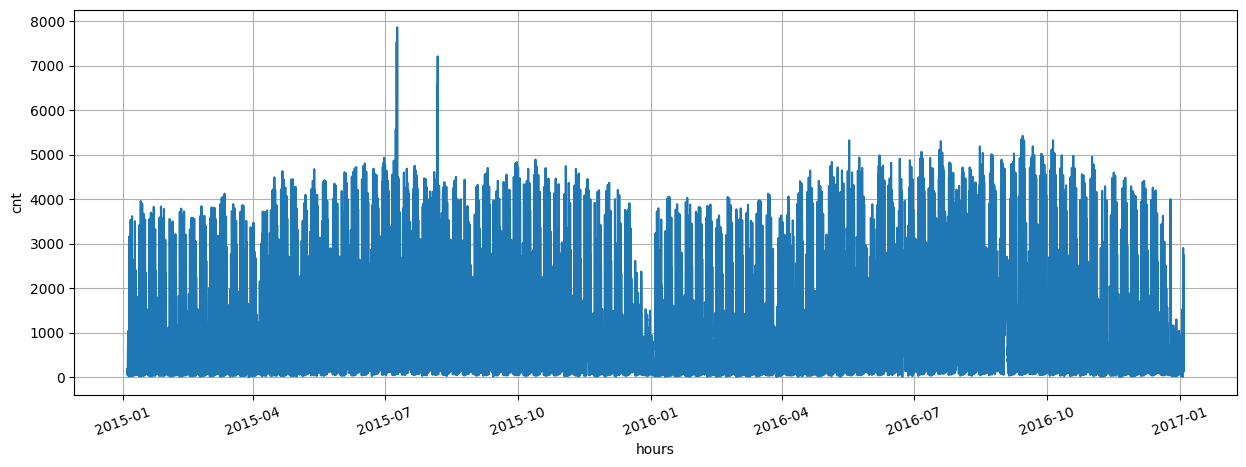

In [89]:
plt.figure(figsize=(15,5))
plt.plot(df.timestamp, df.cnt)
plt.xticks(rotation=20)
plt.xlabel('hours')
plt.ylabel('cnt')
plt.grid()
plt.show()

In [ ]:
# Too hard to see the cyclical nature, let's plot daily graph

In [116]:
pd.plotting.register_matplotlib_converters()

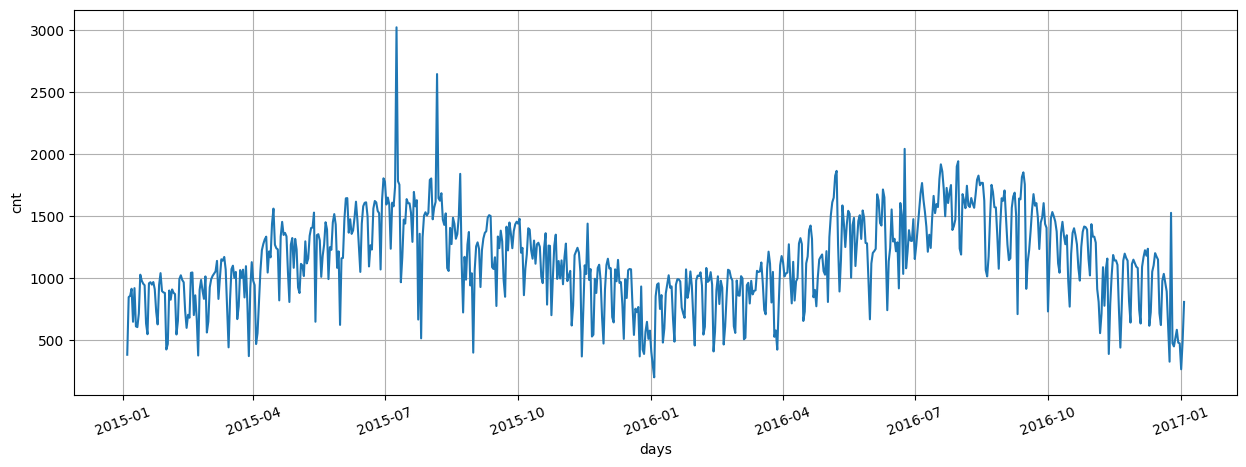

In [114]:
plt.figure(figsize=(15,5))
plt.plot(df.groupby([df.timestamp.dt.date]).agg('mean')['cnt'])
plt.xticks(rotation=20)
plt.xlabel('days')
plt.ylabel('cnt')
plt.grid()
plt.show()

In [ ]:
# Cyclicity can be seen: in the summer they take more bicycles than in other seasons

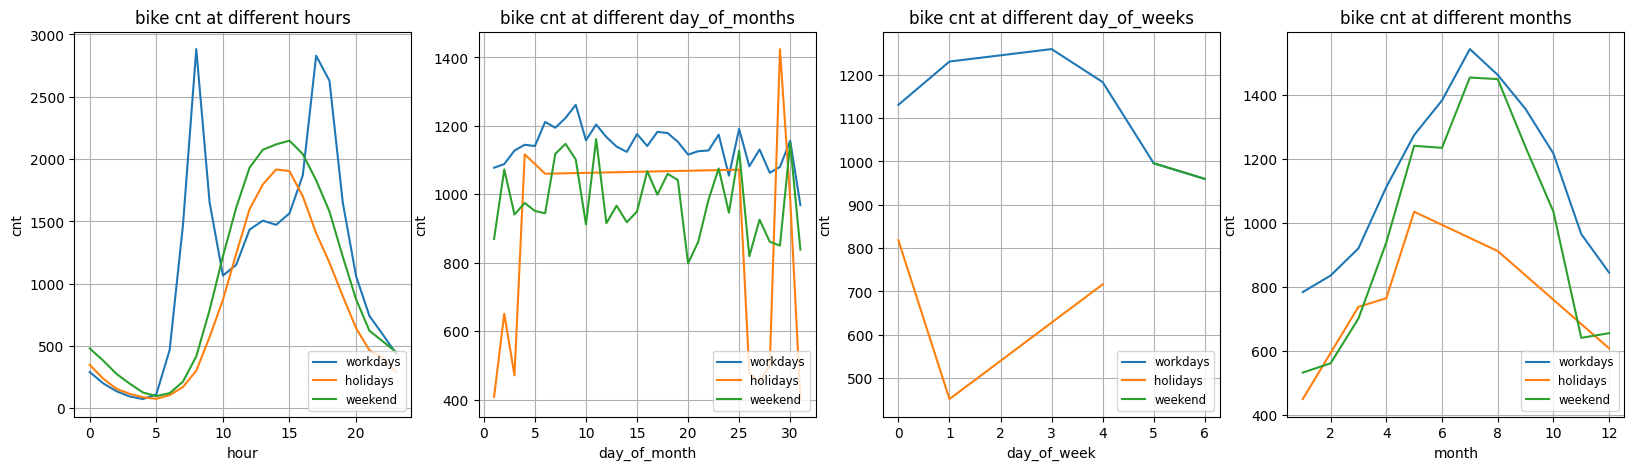

In [88]:
fig, axs = plt.subplots(1,4, figsize=(20,5))
plt.subplots_adjust(wspace = 0.2, hspace = 1)
for i, col in enumerate(df.columns[-4:]):
  axs[i].plot(df.groupby([col]).agg('mean')['cnt'])
  axs[i].plot(df.groupby(['is_holiday',col]).agg('mean')['cnt'][1])
  axs[i].plot(df.groupby(['is_weekend',col]).agg('mean')['cnt'][1])
  axs[i].legend(['workdays','holidays','weekend'],loc=4, fontsize = 'small')
  axs[i].grid()
  axs[i].set_xlabel(col)
  axs[i].set_ylabel('cnt')
  axs[i].set_title('bike cnt at different {}s'.format(col))

In [ ]:
# First plot: most often people rent bicycles at 8 am when they go to work or
# school and 5 pm when they return home. On weekends or holidays, people take a 
# bike closer to lunch.
# Second plot: the day of the month does not have much impact on the rental
# Third plot: on workday rent a little bit more often then holidays and weekend
# Fourth plot: summer is the best time to sell for rent bikes

In [118]:
# Let's onehotencode weather_code and season 

In [11]:
def cols_encoder(col):
    le = LabelEncoder()
    ohe = OneHotEncoder(sparse=False)
    a = le.fit_transform(df[col]).reshape(-1,1)
    col_names = [col + "_"+str(i)for i in le.classes_]
    temp_df = pd.DataFrame(ohe.fit_transform(a),columns = col_names)
    return temp_df

In [ ]:
# Example

In [12]:
cols_encoder('weather_code').head()

,weather_code_1,weather_code_2,weather_code_3,weather_code_4,weather_code_7,weather_code_10,weather_code_26
0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
1,1.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1.0,0.0,0.0,0.0,0.0,0.0,0.0
4,1.0,0.0,0.0,0.0,0.0,0.0,0.0


In [13]:
 df_1 = pd.concat([df, cols_encoder('weather_code'), cols_encoder('season')], axis=1).drop(['season', 'weather_code'], axis = 1)

In [ ]:
# Let's normalize numeric data

In [14]:
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(df_1[['cnt','t1','t2','hum']].values)
df_1[['cnt','t1','t2','hum']] = scaled_data

In [ ]:
# Reset indexes

In [15]:
df_1 = df_1.set_index(df_1.timestamp).drop(['timestamp'], axis = 1)

In [16]:
df_1.head()

,cnt,t1,t2,hum,wind_speed,is_holiday,is_weekend,hour,day_of_month,day_of_week,month,weather_code_1,weather_code_2,weather_code_3,weather_code_4,weather_code_7,weather_code_10,weather_code_26,season_0,season_1,season_2,season_3
timestamp,,,,,,,,,,,,,,,,,,,,,,
2015-01-04 00:00:00,0.023155,0.126761,0.2000,0.911950,6.0,0.0,1.0,0,4,6,1,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2015-01-04 01:00:00,0.017557,0.126761,0.2125,0.911950,5.0,0.0,1.0,1,4,6,1,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2015-01-04 02:00:00,0.017048,0.112676,0.2125,0.955975,0.0,0.0,1.0,2,4,6,1,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2015-01-04 03:00:00,0.009160,0.098592,0.2000,1.000000,0.0,0.0,1.0,3,4,6,1,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2015-01-04 04:00:00,0.005980,0.098592,0.1500,0.911950,6.5,0.0,1.0,4,4,6,1,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


In [ ]:
# Create test and train data

In [17]:
train_size = int(len(df_1) * 0.9)
test_size = len(df_1) - train_size
train, test = df_1.iloc[0:train_size], df_1.iloc[train_size:len(df_1)]
train = train.values
test = test.values
print('Train size: {}\nTest size: {}'.format(len(train), len(test)))

Train size: 15672
Test size: 1742


In [ ]:
# Divide the data into sequences and targets
# How it works?
# For example: we have main sequence 1,2,3...8 and step = 3
# We take first three elements (three because step = 3) from main sequence. This
# will be first_seq = 1,2,3 then 4 is the target we want predict. Move one 
# element to the right, then second_seq = 2,3,4 and 5 is the target we 
# want predict and so on. As we can see sixth_seq don't have target.

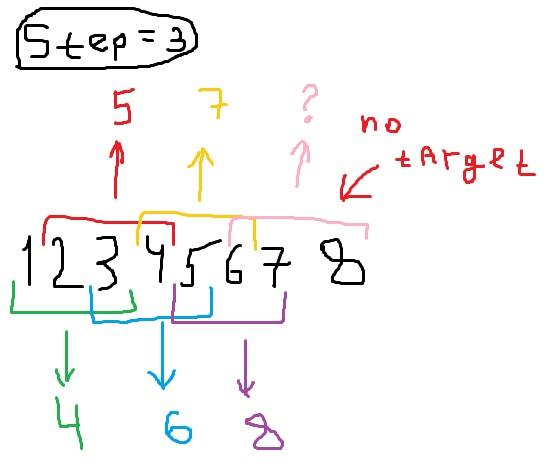

In [ ]:
# In the end we have following sequences and targets:

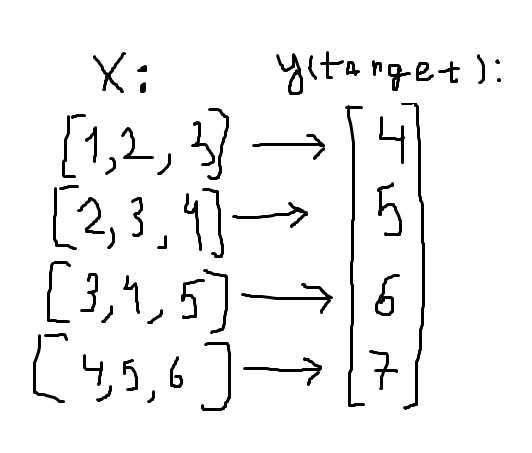

In [127]:
# Function that creates sequences and targets

In [18]:
def X_y(X, y, steps=1):
  X_array, y_array = [], []
  for i in range(X.shape[0]-steps):
    seq = X[i:(i + steps)]
    target = y[(i + steps)]
    X_array.append(seq)
    y_array.append(target)
  return np.array(X_array), np.array(y_array)

In [19]:
steps = 10

In [20]:
X_train, y_train = X_y(train, train[:,0], steps)
X_test, y_test = X_y(test, test[:,0], steps)

In [21]:
X_train.shape

(15662, 10, 22)

In [22]:
y_train.shape

(15662,)

In [23]:
print('Train: {} samples of {} timestamp of {} features'.format(X_train.shape[0],
                                                                X_train.shape[1],
                                                                X_train.shape[2]))

Train: 15662 samples of 10 timestamp of 22 features


In [24]:
print('Test: {} samples of {} timestamp of {} features'.format(X_test.shape[0],
                                                                X_test.shape[1],
                                                                X_test.shape[2]))

Test: 1732 samples of 10 timestamp of 22 features


In [ ]:
# Create the model. Main layer in the model is LSTM that can grind 
# sequences

In [25]:
model = Sequential()
model.add(Bidirectional(LSTM(units=128,
                             input_shape=(X_train.shape[1], X_train.shape[2]),
                             return_sequences=False)))
model.add(Dropout(0.2))
model.add(Dense(1))

In [26]:
model.compile(loss='mean_squared_error', optimizer='adam', metrics=['MAE'])

In [ ]:
# Fit the model

In [27]:
history = model.fit(
    X_train, y_train,
    epochs=30,
    batch_size=32,
    validation_split=0.1)

Epoch 1/30
441/441 [==============================] - 23s 9ms/step - loss: 0.0691 - MAE: 0.1913 - val_loss: 0.0086 - val_MAE: 0.0718
Epoch 2/30
441/441 [==============================] - 3s 7ms/step - loss: 0.0077 - MAE: 0.0666 - val_loss: 0.0050 - val_MAE: 0.0456
Epoch 3/30
441/441 [==============================] - 3s 7ms/step - loss: 0.0039 - MAE: 0.0463 - val_loss: 0.0029 - val_MAE: 0.0356
Epoch 4/30
441/441 [==============================] - 3s 7ms/step - loss: 0.0027 - MAE: 0.0373 - val_loss: 0.0023 - val_MAE: 0.0307
Epoch 5/30
441/441 [==============================] - 3s 7ms/step - loss: 0.0022 - MAE: 0.0328 - val_loss: 0.0016 - val_MAE: 0.0258
Epoch 6/30
441/441 [==============================] - 3s 7ms/step - loss: 0.0018 - MAE: 0.0296 - val_loss: 0.0019 - val_MAE: 0.0284
Epoch 7/30
441/441 [==============================] - 3s 7ms/step - loss: 0.0015 - MAE: 0.0270 - val_loss: 0.0021 - val_MAE: 0.0329
Epoch 8/30
441/441 [==============================] - 3s 7ms/step - loss: 0

In [ ]:
# Evaluate the model

In [129]:
print('val_loss and val_MAE:',model.evaluate(X_test,y_test))

55/55 [==============================] - 0s 3ms/step - loss: 7.1459e-04 - MAE: 0.0189
val_loss and val_MAE: [0.0007145914132706821, 0.0189343448728323]


In [ ]:
# Plot fitting graph

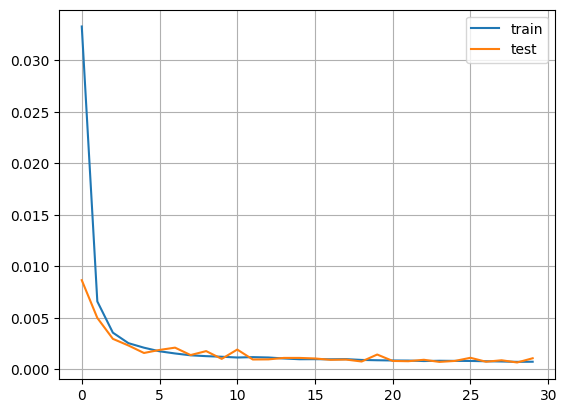

In [35]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.grid()
plt.legend()

In [ ]:
# Let's transform the normalized numeric data back 
# (y_predictions, y_test, y_train) 

In [30]:
y_pred = scaler.inverse_transform(np.concatenate([model.predict(X_test), np.zeros((model.predict(X_test).shape[0], 3))], axis = 1))[:,0]

In [31]:
y_test_real = scaler.inverse_transform(np.concatenate([y_test.reshape(-1,1), np.zeros((y_test.shape[0], 3))], axis = 1))[:,0]

In [32]:
y_train_real = scaler.inverse_transform(np.concatenate([y_train.reshape(-1,1), np.zeros((y_train.shape[0], 3))], axis = 1))[:,0]

In [ ]:
# Predictions plot

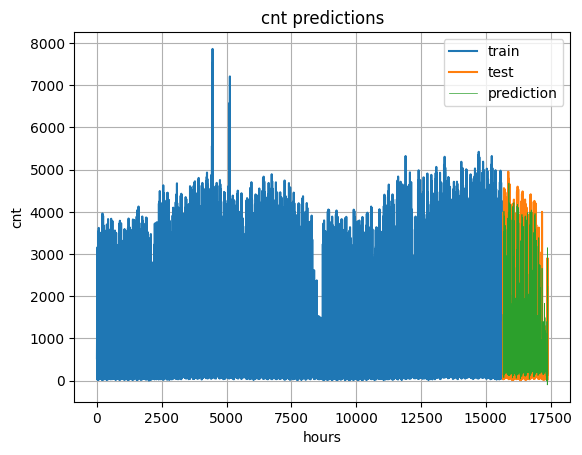

In [36]:
plt.plot(range(len(y_train_real)),
         y_train_real,
         label='train')
plt.plot(range(len(y_train_real),len(y_train_real)+len(y_test_real)), 
         y_test_real, 
         alpha=1, 
         label='test')
plt.plot(range(len(y_train_real),len(y_train_real)+len(y_pred)),
         y_pred,
         alpha=1,
         linewidth=0.5,
         label='prediction')
plt.title('cnt predictions')
plt.xlabel('hours')
plt.ylabel('cnt')
plt.grid()
plt.legend()
plt.show()

In [ ]:
# Zoomed

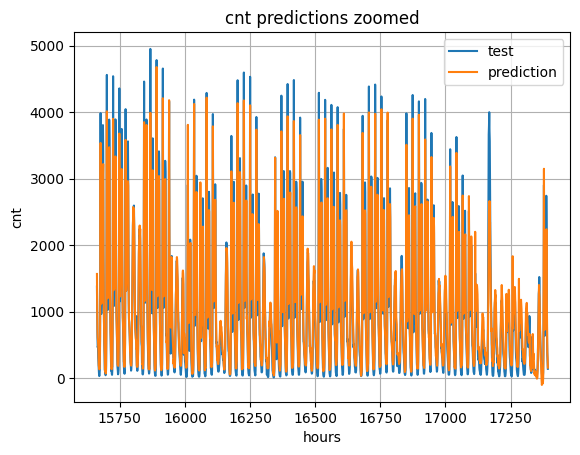

In [37]:
plt.plot(range(len(y_train_real),len(y_train_real)+len(y_test_real)), 
         y_test_real, 
         label='test')
plt.plot(range(len(y_train_real),len(y_train_real)+len(y_pred)),
         y_pred,
         label='prediction')
plt.title('cnt predictions zoomed')
plt.xlabel('hours')
plt.ylabel('cnt')
plt.grid()
plt.legend()
plt.show()

In [ ]:
# Not bad! The model saw cyclicality in the data and learned to predict it

In [130]:
# Let's try improve a little bit the model by adding second LSTM layes.
# Don't forget assign return_sequences = True for first LSTM layer
# LSTM working only with sequences.

In [47]:
model_2 = Sequential()
model_2.add(Bidirectional(LSTM(units=128,
                             input_shape=(X_train.shape[1], X_train.shape[2]),
                             return_sequences=True)))
model_2.add(Bidirectional(LSTM(units=128)))
model_2.add(Dropout(0.2))
model_2.add(Dense(1))

In [48]:
model_2.compile(loss='mean_squared_error', optimizer='adam', metrics = ['MAE'])

In [49]:
history_1 = model_2.fit(
    X_train, y_train,
    epochs=30,
    batch_size=32,
    validation_split=0.1)

Epoch 1/30
441/441 [==============================] - 13s 13ms/step - loss: 0.0591 - MAE: 0.1573 - val_loss: 0.0084 - val_MAE: 0.0608
Epoch 2/30
441/441 [==============================] - 4s 10ms/step - loss: 0.0060 - MAE: 0.0568 - val_loss: 0.0048 - val_MAE: 0.0473
Epoch 3/30
441/441 [==============================] - 4s 10ms/step - loss: 0.0029 - MAE: 0.0384 - val_loss: 0.0027 - val_MAE: 0.0351
Epoch 4/30
441/441 [==============================] - 4s 10ms/step - loss: 0.0023 - MAE: 0.0331 - val_loss: 0.0019 - val_MAE: 0.0285
Epoch 5/30
441/441 [==============================] - 4s 10ms/step - loss: 0.0019 - MAE: 0.0292 - val_loss: 0.0021 - val_MAE: 0.0308
Epoch 6/30
441/441 [==============================] - 4s 10ms/step - loss: 0.0017 - MAE: 0.0278 - val_loss: 0.0017 - val_MAE: 0.0285
Epoch 7/30
441/441 [==============================] - 4s 10ms/step - loss: 0.0015 - MAE: 0.0247 - val_loss: 0.0018 - val_MAE: 0.0325
Epoch 8/30
441/441 [==============================] - 4s 10ms/step -

In [131]:
print('val_loss and val_MAE:',model_2.evaluate(X_test,y_test))

55/55 [==============================] - 0s 5ms/step - loss: 5.2380e-04 - MAE: 0.0151
val_loss and val_MAE: [0.0005237996811047196, 0.015113373287022114]


In [ ]:
# The val_loss and val_MAE less than that of the first model

In [51]:
y_pred_1 = scaler.inverse_transform(np.concatenate([model_2.predict(X_test), np.zeros((model_2.predict(X_test).shape[0], 3))], axis = 1))[:,0]

In [52]:
y_test_real_1 = scaler.inverse_transform(np.concatenate([y_test.reshape(-1,1), np.zeros((y_test.shape[0], 3))], axis = 1))[:,0]

In [54]:
y_train_real_1 = scaler.inverse_transform(np.concatenate([y_train.reshape(-1,1), np.zeros((y_train.shape[0], 3))], axis = 1))[:,0]

In [ ]:
# Predictions plot

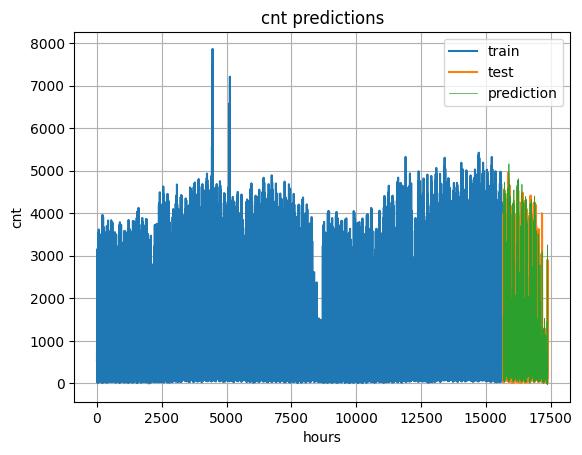

In [55]:
plt.plot(range(len(y_train_real_1)),
         y_train_real_1,
         label='train')
plt.plot(range(len(y_train_real_1),len(y_train_real_1)+len(y_test_real_1)), 
         y_test_real_1, 
         alpha=1, 
         label='test')
plt.plot(range(len(y_train_real_1),len(y_train_real_1)+len(y_pred_1)),
         y_pred_1,
         alpha=1,
         linewidth=0.5,
         label='prediction')
plt.title('cnt predictions')
plt.xlabel('hours')
plt.ylabel('cnt')
plt.grid()
plt.legend()
plt.show()

In [ ]:
# Zoomed

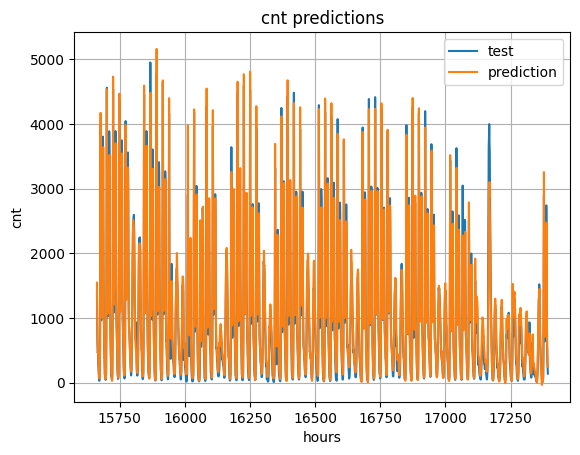

In [57]:
plt.plot(range(len(y_train_real_1),len(y_train_real_1)+len(y_test_real_1)), 
         y_test_real_1, 
         label='test')
plt.plot(range(len(y_train_real_1),len(y_train_real_1)+len(y_pred_1)),
         y_pred_1,
         label='prediction')
plt.title('cnt predictions')
plt.xlabel('hours')
plt.ylabel('cnt')
plt.grid()
plt.legend()
plt.show()

In [162]:
# Indeed, the second model is better at predicting